In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

import plotly.offline as py 
py.init_notebook_mode(connected=True)                  
import plotly.graph_objs as go                         
import plotly.tools as tls                             
from collections import Counter                        
import plotly.figure_factory as ff
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [33]:
df = pd.read_csv("german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


#The first eight columns are the feature variables and the last column (Risk) is the target
#variable, which we want to classify as “good” or “bad”. The purpose of the Machine
#Learning model is to capture the relations between the features and the target variables and predict the credit risk for future applicants.

# Exploratory Data Analysis

Are females more likely to default or is it less risky to lend money to rich people? These kinds of questions can qualitatively be answered by visualizing the data. We create a sub-table for each feature variable in question.


In [35]:
df_sm = df.copy()

In [36]:
#cross table for the 'Sex' feature

In [37]:
cross_sex = pd.crosstab(df['Risk'], df['Sex']).apply(lambda x: x/x.sum() * 100)
decimals = pd.Series([2,2], index=['Male', 'Female'])
cross_sex = cross_sex.round(decimals)
cross_sex_transposed = cross_sex.T
cross_sex_transposed.style.background_gradient(cmap='Blues')

Risk,bad,good
Sex,,
female,35.161290,64.838710
male,27.681159,72.318841


The values presented here are in percentage. It seems, the feature “Sex” contains valuable information for the classification. In this data set, females are slightly more likely to default (however, this cannot be used as a general conclusion). We can better perceive it from the graph below

# Age and Sex Distributons¶


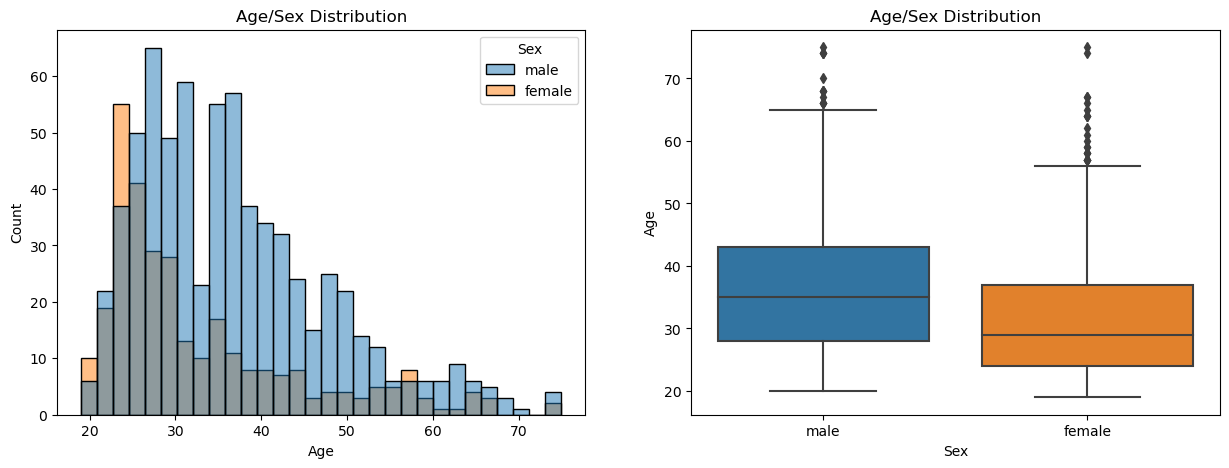

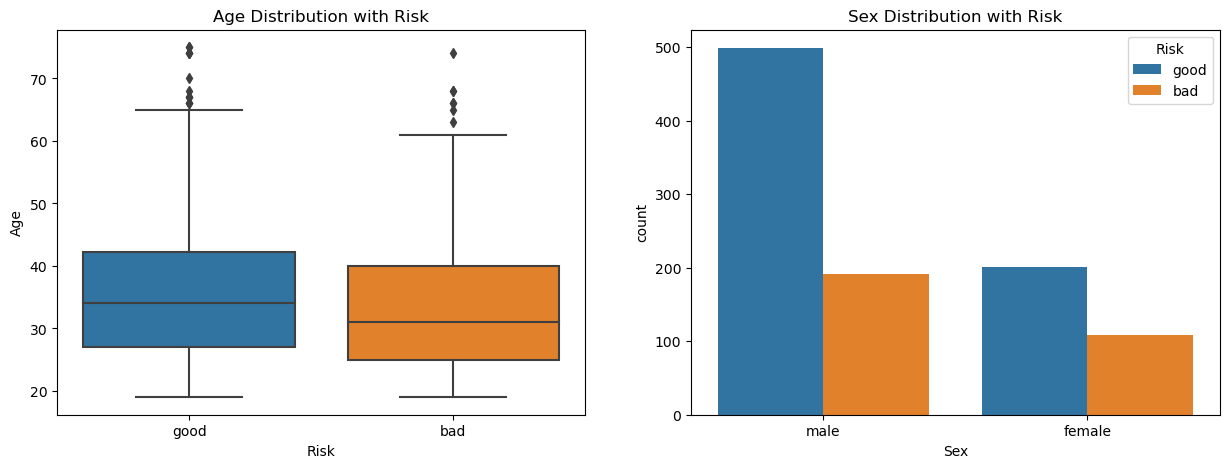

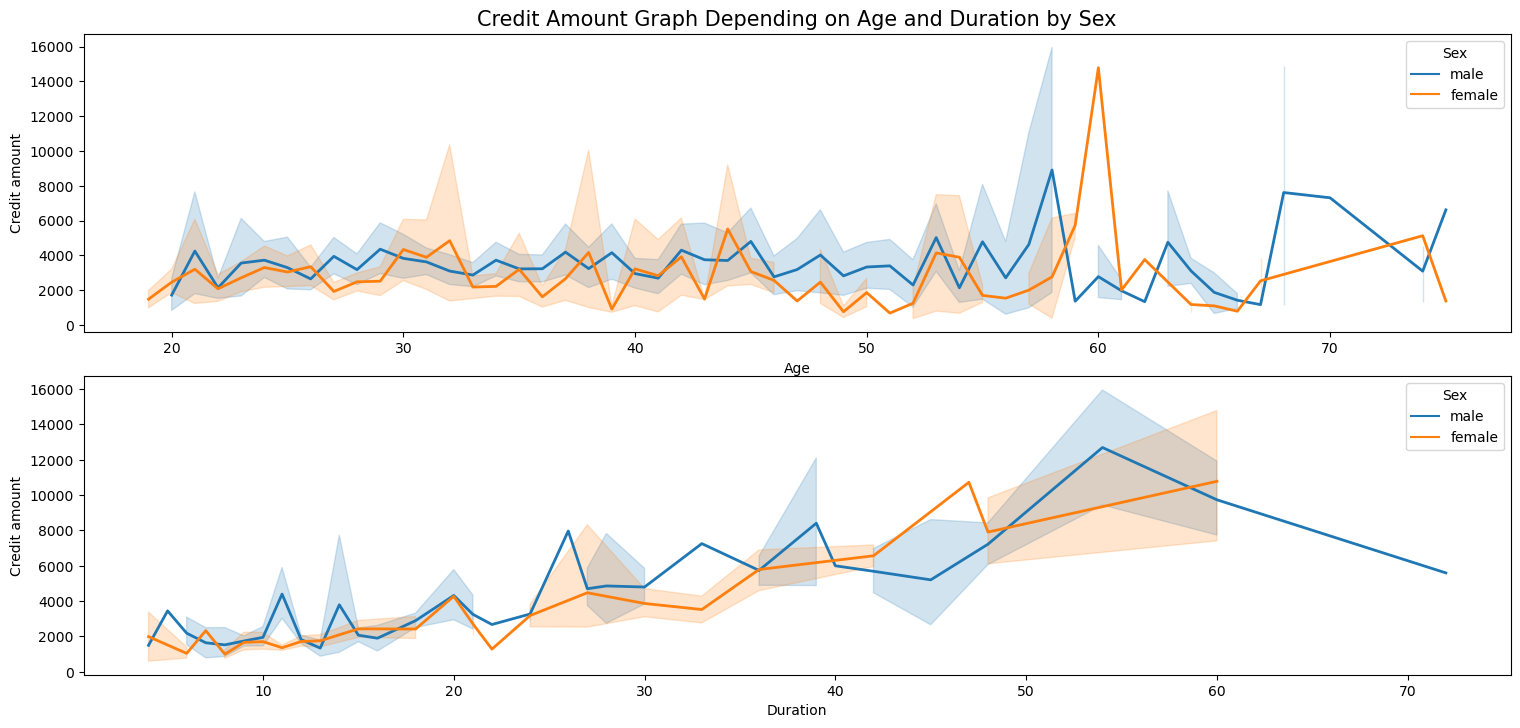

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df, x='Age', bins=30, hue="Sex", ax=ax[0]).set_title("Age/Sex Distribution");
sns.boxplot(data=df, x="Sex", y="Age", ax=ax[1]).set_title("Age/Sex Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df, x='Risk', y='Age', ax=ax[0]).set_title("Age Distribution with Risk");
sns.countplot(data=df, x="Sex", hue="Risk", ax=ax[1]).set_title("Sex Distribution with Risk");

fig, ax = plt.subplots(2,1,figsize=(15,7))
plt.tight_layout()
sns.lineplot(data=df, x='Age', y='Credit amount', hue='Sex', lw=2, ax=ax[0]).set_title("Credit Amount Graph Depending on Age and Duration by Sex", fontsize=15);
sns.lineplot(data=df, x='Duration', y='Credit amount', hue='Sex', lw=2, ax=ax[1]);

Looking at the chart, the highest credit amount was reached at the age of 60 and around.
Looking at the graph, the highest loan amounts between 50-60 duration have been reached.

This code is creating 3 bar charts (histograms) to visualize how age is distributed among people with:

Good credit

Bad credit

Everyone (overall)

In [39]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit",
    marker=dict(
        color='#85ead9'
    )
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit",
    marker=dict(
        color='#6f2cea'
    )
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age",
    marker=dict(
        color='#f392f4'
    )
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Why It’s Useful
This helps us answer questions like:

Are younger or older people more likely to have bad credit?

Is the average age different for good vs. bad credit?

Do age groups behave differently in credit risk?

In [40]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df_sm["Age_cat"] = pd.cut(df_sm.Age, interval, labels=cats)


df_good = df_sm[df_sm["Risk"] == 'good']
df_bad = df_sm[df_sm["Risk"] == 'bad']

Why This Is Useful
It lets you:

Group people into meaningful age buckets

Analyze credit behavior by age group

Do age-wise segmentation for targeted analysis (e.g., do seniors take higher loans? Are students riskier?)

Creating a boxplot to compare the credit amount across different age groups for people with:

Good credit

Bad credit

In [41]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#50f466'
    )
)

#This creates a boxplot showing how the credit amount is distributed for each age group (Student, Young, etc.)
# — but only for people with good credit.

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#b2014e'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [42]:
#First plot
trace0 = go.Bar(
                x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
                y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Housing Distribuition')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Housing-Grouped')
plt.show()

This code creates a grouped bar chart comparing the types of housing (like own, rent, free) between:

People with good credit

People with bad credit

Why This Is Useful?
It helps answer:

Does owning a house relate to better credit?

Are renters more likely to be high-risk?

What housing type is most common in each credit category?

Great for risk analysis or demographic profiling.

creating a grouped bar chart comparing job types between good and bad credit holders, and then trying to plot histograms of credit amount.

In [43]:
#First plot
trace0 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'good']["Job"].value_counts().values,
                name='Good credit',
                marker=dict(
                color='#a4e23f'
                    )
                )

#Second plot
trace1 = go.Bar(
                x = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().index.values,
                y = df_sm[df_sm["Risk"]== 'bad']["Job"].value_counts().values,
                name="Bad Credit",
                marker=dict(
                color='#b2014e'
                    )
                )

data = [trace0, trace1]

layout = go.Layout(title='Job Distribuitio')


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Job-Grouped')
plt.show()

Want to understand how credit amount and loan duration are distributed overall — and how they differ by risk (good vs bad credit).

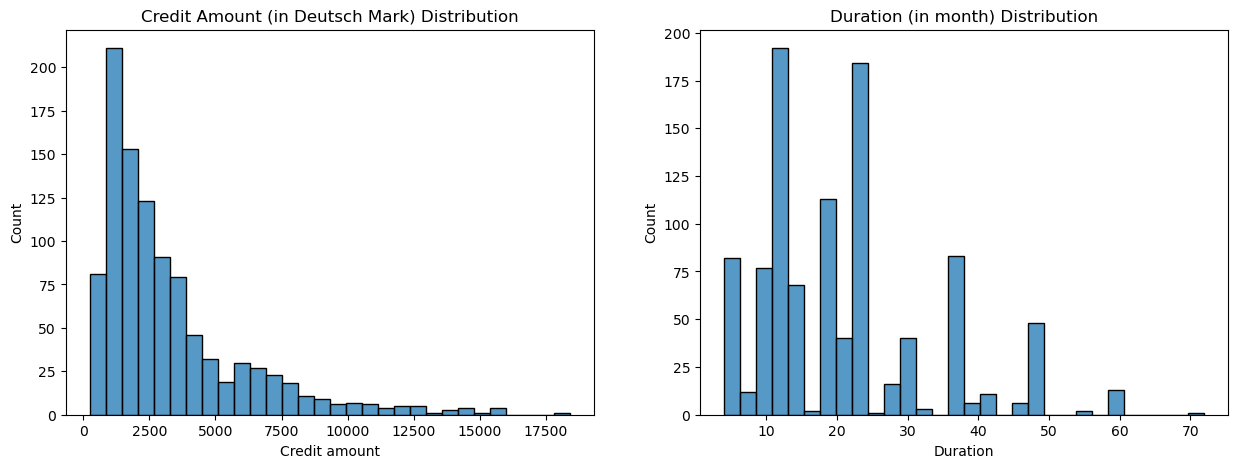

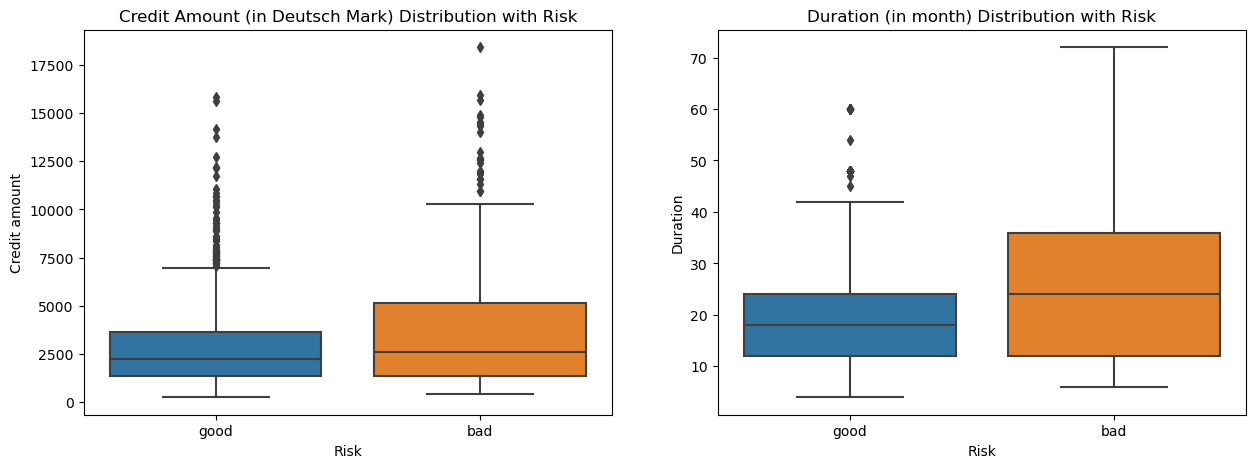

In [44]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_sm, x='Credit amount', bins=30, ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution");
sns.histplot(df_sm, x='Duration', bins=30, ax=ax[1]).set_title("Duration (in month) Distribution");

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=df_sm, x='Risk', y='Credit amount', ax=ax[0]).set_title("Credit Amount (in Deutsch Mark) Distribution with Risk");
sns.boxplot(data=df_sm, x='Risk', y='Duration', ax=ax[1]).set_title("Duration (in month) Distribution with Risk");

Left plot: Shows how many people took loans of different amounts.

Right plot: Shows how many people had loans of different durations (in months).

These are histograms, like bar charts showing how values are spread out.

These are boxplots, which show the range, average, and outliers.

You’re comparing credit amount and loan duration for people with good vs. bad credit.

It tells you things like:

Do people with bad credit borrow more?

Do they borrow for longer durations?

In [51]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying original df_sm
df_encoded = df_sm.copy()

# Columns that need encoding
cols_to_encode = ['Job', 'Housing', 'Saving accounts', 'Checking account']

# Apply Label Encoding
le = LabelEncoder()
for col in cols_to_encode:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


In [52]:
corr = df_encoded[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']].corr()


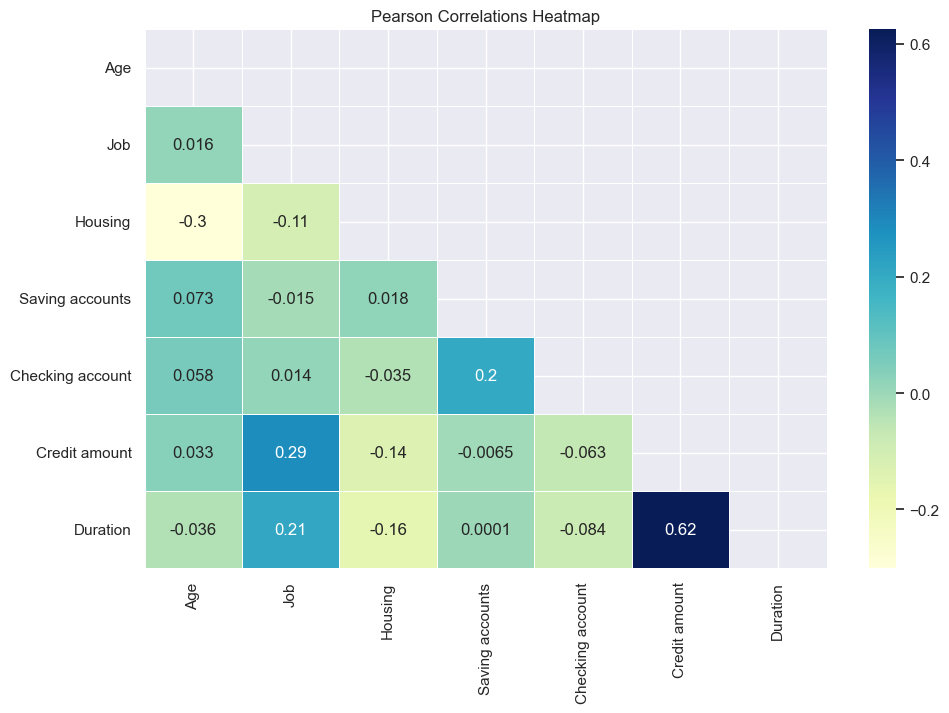

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(11,7)})
mask = np.triu(np.ones_like(corr, dtype=bool))  # mask upper triangle

sns.heatmap(corr, linewidths=.5, annot=True, cmap="YlGnBu", mask=mask).set_title("Pearson Correlations Heatmap")
plt.show()


Handle Missing Values¶
Most Machine Learning models cannot handle missing values within the feature space, or these can adversely diminish the prediction power of the model. Therefore, we need to check for them

In [54]:
df.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Quickly checking:

What categories exist in each of your key text columns.

Helps identify data issues (e.g., typos like 'male ' vs 'male')

Helps you prepare for encoding, visualization, or modeling by knowing:

How many unique values each column has

Whether a variable is binary (2 values) or multi-class

In [56]:
display(Markdown("#### Explore the Values of Text Columns:"))
cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']
for col in cols:
    line = "**" + col + ":** "
    for v in df[col].unique():
        line = line + str(v) + ", "
    display(Markdown(line))

#### Explore the Values of Text Columns:

**Sex:** male, female, 

**Housing:** own, free, rent, 

**Saving accounts:** nan, little, quite rich, rich, moderate, 

**Checking account:** little, moderate, nan, rich, 

**Purpose:** radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others, 

**Risk:** good, bad, 

In [58]:
# label encode account quality and fill NaN with 0
def SC_LabelEncoder(text):
    if text == "little":
        return 1
    elif text == "moderate":
        return 2
    elif text == "quite rich":
        return 3
    elif text == "rich":
        return 4
    else:
        return 0

df["Saving accounts"] = df["Saving accounts"].apply(SC_LabelEncoder)
df["Checking account"] = df["Checking account"].apply(SC_LabelEncoder)

👉 This function converts text categories into numbers:

'little' → 1

'moderate' → 2

'quite rich' → 3

'rich' → 4

Any missing or unknown value (like NaN) → 0

## Machine learning models can’t work with text — they need numbers.

This label encoding allows you to:

Analyze correlations

Train models

Visualize numeric trends

And by assigning 0 to missing values, you're also filling NaNs, avoiding errors during modeling.

In [59]:
# label encode account quality and fill NaN with 0
def H_LabelEncoder(text):
    if text == "free":
        return 0
    elif text == "rent":
        return 1
    elif text == "own":
        return 2

df["Housing"] = df["Housing"].apply(H_LabelEncoder)

# Data Pre-processing For Discrete Categorical Columns¶
From the raw data we saw that the target variable risk is categorical (‘good’ or ‘bad’). Therefore, this is a classification problem. There are many classification algorithms in the literature with the Random Forest classifier being considered one of the standard classifiers.

In [64]:
from sklearn.preprocessing import LabelEncoder

for col in ["Sex", "Purpose", "Risk"]:  # Removed 'Age'
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,48,1,2,2,0,0,1169,6,5,1
1,1,3,0,2,2,0,0,5951,48,5,0
2,2,30,1,1,2,0,0,2096,12,3,1
3,3,26,1,2,0,0,0,7882,42,4,1
4,4,34,1,2,0,0,0,4870,24,1,0


For each column listed:

Create a new LabelEncoder

fit() tells the encoder what unique values exist (e.g., "male", "female")

transform() converts the column values into numeric codes

So for example:

"Sex": "male" → 1, "female" → 0

"Purpose": "radio/tv" → 0, "education" → 1, etc.

"Risk": "good" → 0, "bad" → 1

⚠️ "Age" is already numeric – including it here is unnecessary and may corrupt real age data.

#### Now that we have all the features and target variable in the numerical form, we can finally train and fit our model. For that we should first split our data into a train set and a test set. The train set would be used to capture the relations between the features and the target variables while the test set will be used to verify the performance of the model.

# Build Model

Clustering¶
Start with applying Elbow Method.¶

In [65]:
cdf = df.drop("Risk", axis=1)

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: Future

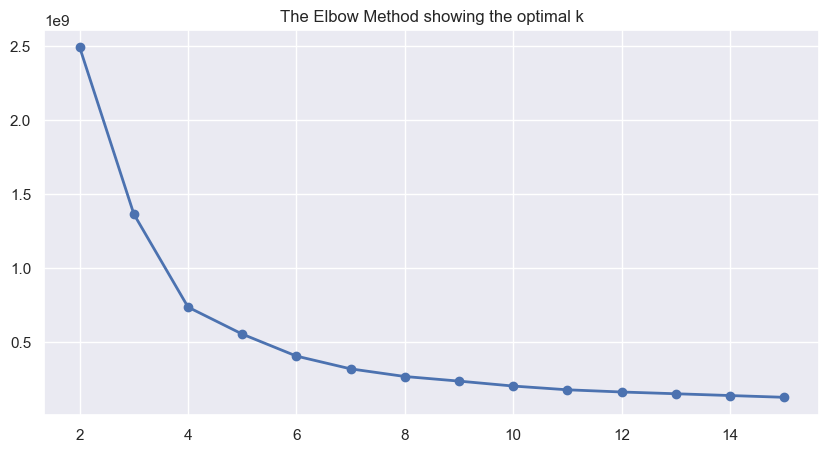

In [67]:
inertias = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(cdf)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.title('The Elbow Method showing the optimal k')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2);

"Inertia" = the sum of distances from each point to its cluster center (a measure of compactness).

Why You’re Using This
To decide the best value of k for KMeans clustering.

Too few clusters → underfitting

Too many clusters → overfitting

The elbow point balances both.

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: Future

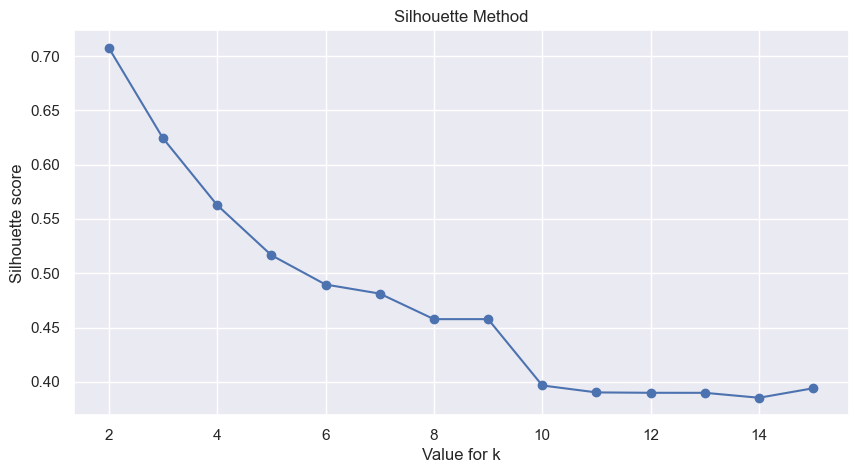

In [68]:
k = range(2,16)
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster).fit(cdf)
    score.append(silhouette_score(cdf,kmeans.labels_))
plt.figure(figsize=(10,5))
plt.plot(k, score, 'o-')
plt.xlabel("Value for k")
plt.ylabel("Silhouette score")
plt.title('Silhouette Method')
plt.show()

Trying to figure out the best number of clusters (k) to use in K-Means Clustering using the Silhouette Method.

Why This Is Useful
The Silhouette Method helps evaluate cluster quality without needing labels.

It gives you a more reliable answer than just the elbow method (which looks at inertia but not separation).



In [70]:
km = KMeans(n_clusters=4, random_state=0)
clusters = km.fit_predict(cdf)

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



 This line does two things:

Fits the model to your dataset cdf (i.e., it finds patterns/groupings in the data).

Predicts the cluster label for each row in the data.

Example: The first row might be labeled 2, second row 0, etc.

The result (clusters) is a list/array of numbers like [2, 0, 1, 3, ...], meaning each row is assigned to one of the 4 clusters.

In [71]:
acc = max((sum(clusters == df["Risk"]) / len(df)), (sum(clusters != df["Risk"]) / len(df)))
display(Markdown("The accuracy rate of 4-Means clustering is " + str(acc)))

The accuracy rate of 4-Means clustering is 0.77

C:\Users\Rohit Kumar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



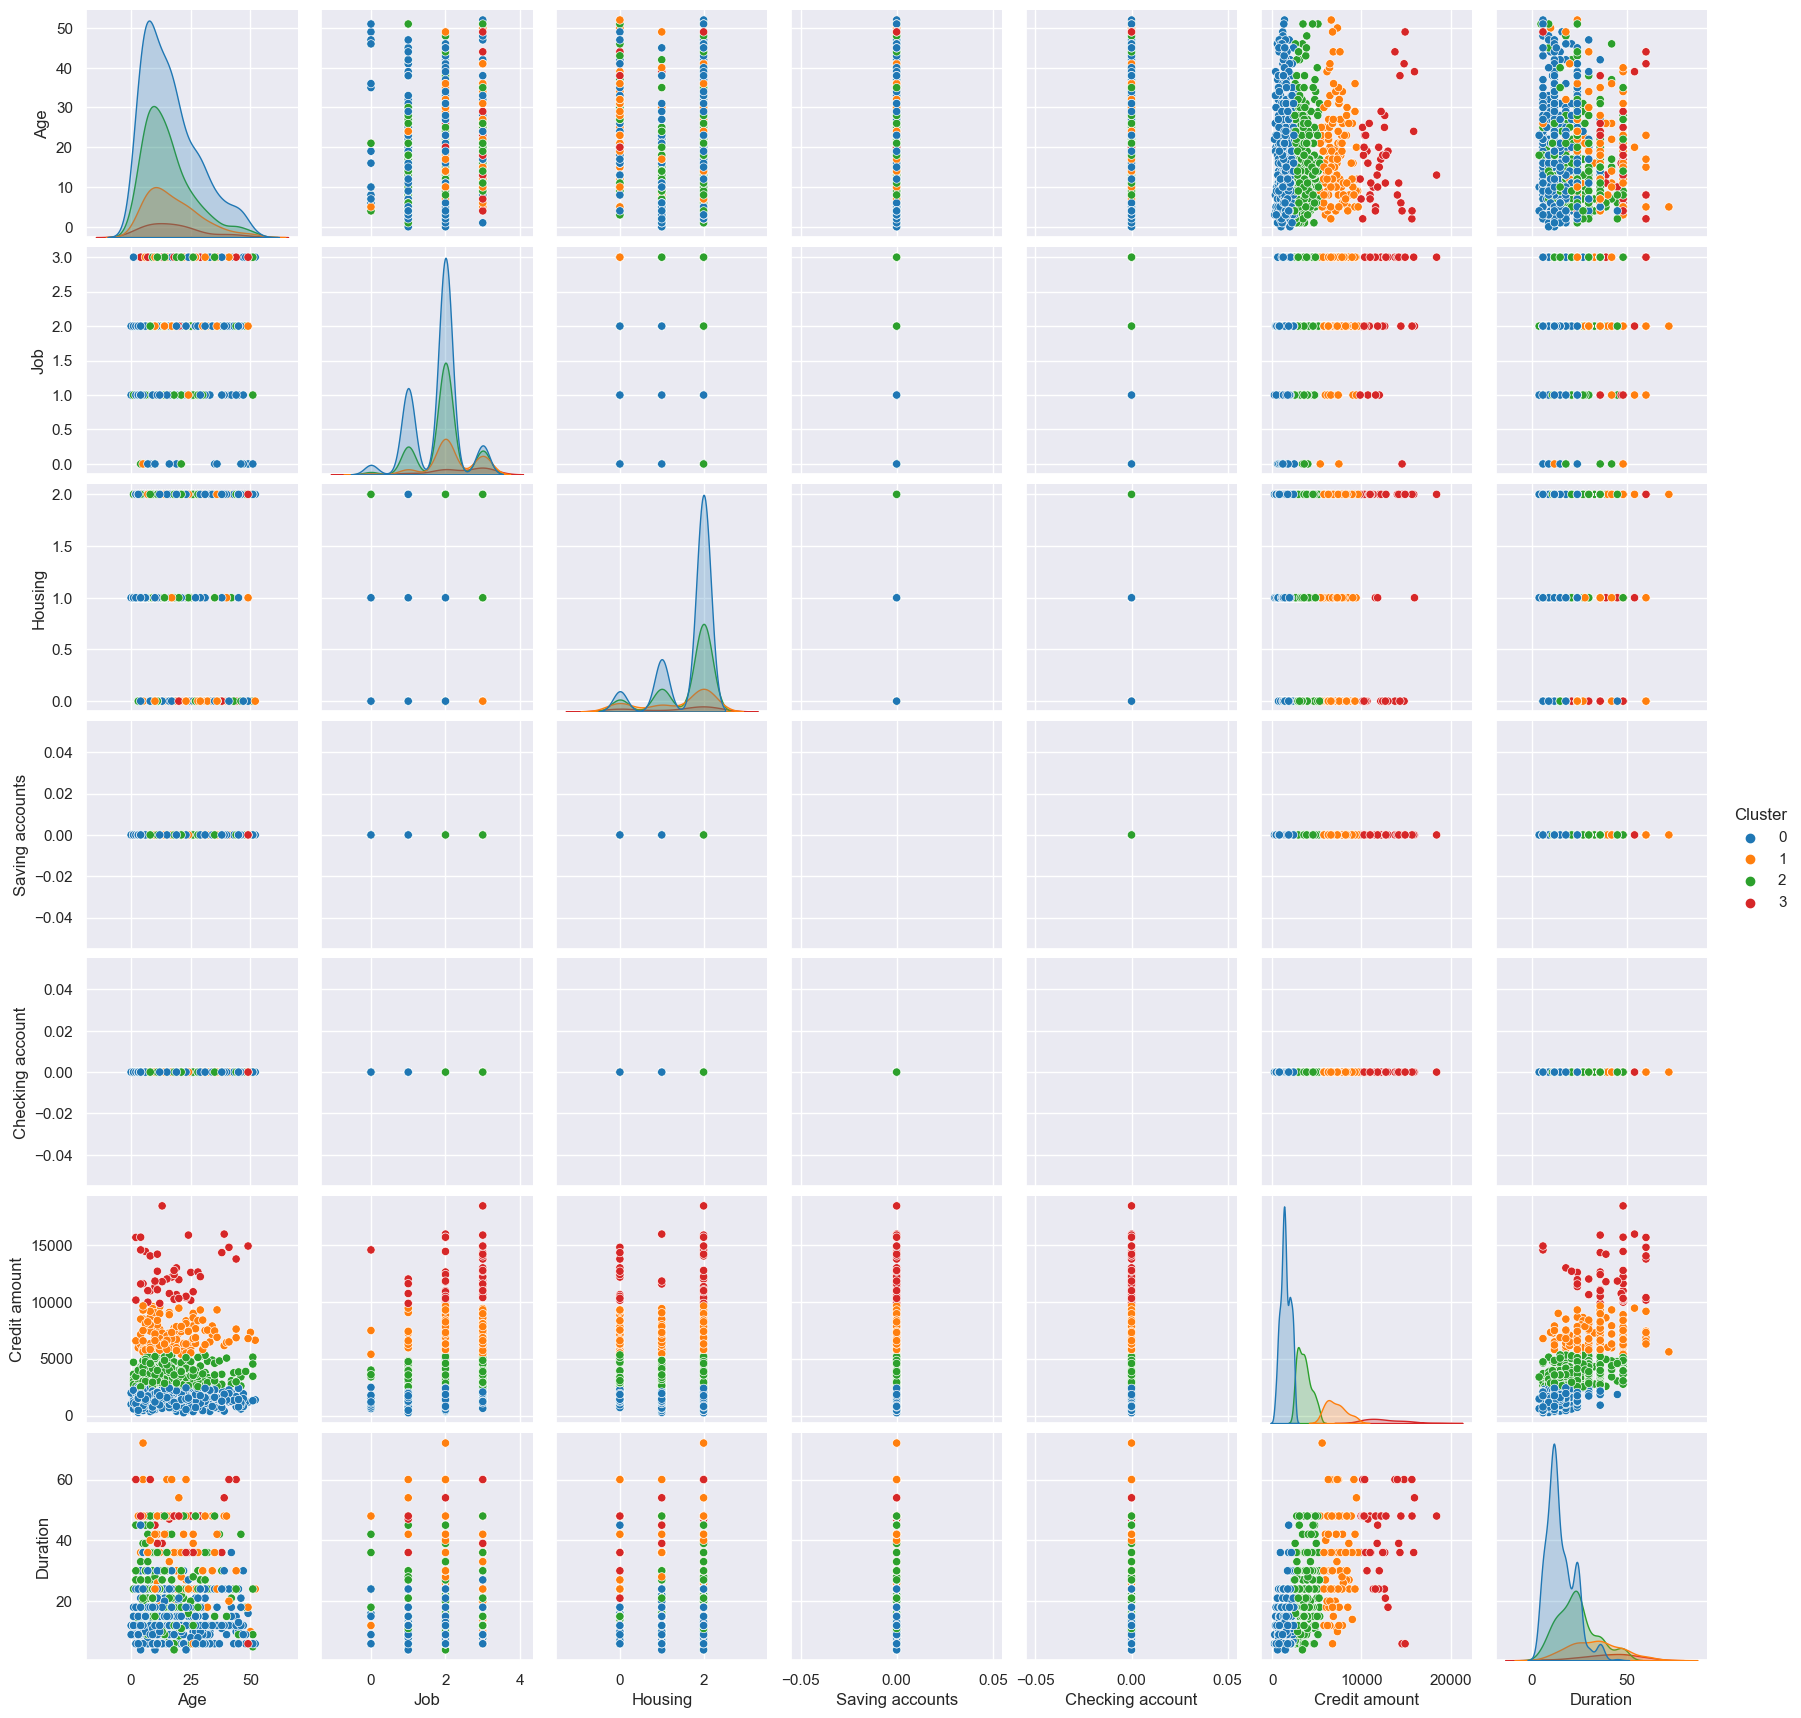

In [72]:
df_clustered = cdf[['Age', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']]
df_clustered["Cluster"] = clusters
sns.pairplot(df_clustered, hue="Cluster",palette='tab10')

To visually inspect how well the clusters are separated.

Helps answer:

Are clusters clearly grouped in any variable pair?

Do some clusters dominate a certain range of credit amount, age, etc.?

Are there overlaps or outliers?

# K-Nearest Neighbors Classification

In [73]:
# Spliting X and y into train and test version
X, y = df.drop("Risk", axis=1), df["Risk"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=0)

In [74]:
max_score = 0
max_k = 0
for k in range(1, 100):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train,y_train)
    score = f1_score(y_test, neigh.predict(X_test))
    if score > max_score:
        max_k = k
        max_score = score

display(Markdown("If use K-Nearest Neighbors Classification, the k should be " + str(max_k) + " to get best prediction, and then the  mean accuracy is " + str(max_score)))

If use K-Nearest Neighbors Classification, the k should be 69 to get best prediction, and then the  mean accuracy is 0.8352941176470587

Why This Is Useful
Tuning a key parameter in KNN to get optimal performance.

Helps prevent overfitting or underfitting.


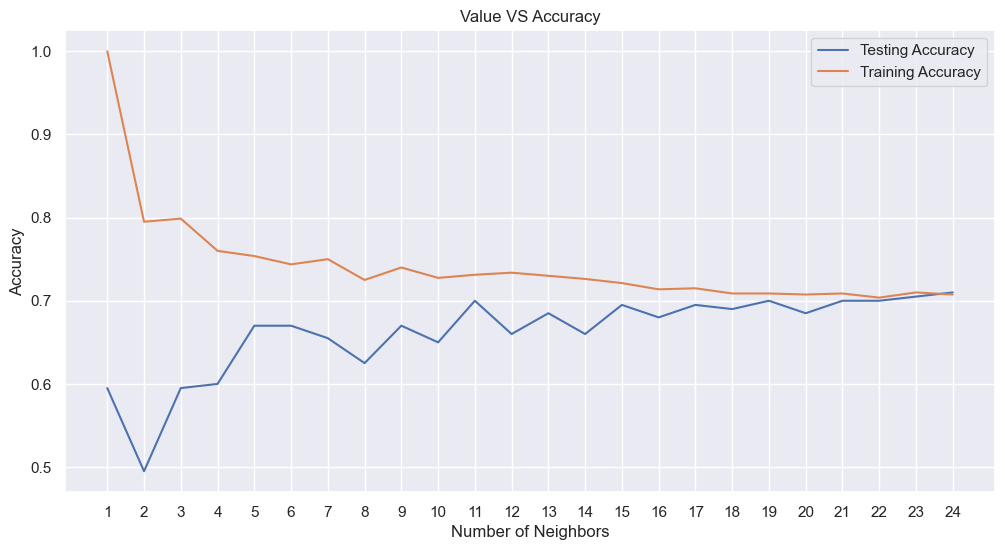

Best accuracy is 0.71 with K = 24


In [75]:
neig = np.arange(1, 25)
train_accuracy = []
test_accuracy = []
# Loop over different values of k
for i, k in enumerate(neig):
    # k from 1 to 25(exclude)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # Fit with knn
    knn_model.fit(X_train,y_train)
    #train accuracy
    train_accuracy.append(knn_model.score(X_train, y_train))
    # test accuracy
    test_accuracy.append(knn_model.score(X_test, y_test))

# Plot
plt.figure(figsize=[12,6])
plt.plot(neig, test_accuracy, label = 'Testing Accuracy')
plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(neig)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))


Modeling by Other Classifiers¶
Since KNN algorithm cost lots of memory and time for prediction, this section want to try some more classifiers.

Model Selection with Cross Validate

In [76]:
# define models
Models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GaussianNaiveBayes": GaussianNB(),
   
}

#  Goal:
To test and compare different machine learning models
setting up a dictionary of 4 models:

SVC → Support Vector Classifier

DecisionTree → Decision Tree

RandomForest → Ensemble of decision trees

GaussianNB → Naive Bayes classifier assuming Gaussian distribution



In [78]:
cv_results = pd.DataFrame(columns=['model', 'train_score', 'test_score'])
for key in Models.keys():
    cv_res = model_selection.cross_validate(Models[key], X_train, y_train, 
                                             return_train_score=True,
                                             scoring="f1",
                                             cv=5, n_jobs=-1)
    res = {
        'model': key, 
        'train_score': cv_res["train_score"].mean(), 
        'test_score': cv_res["test_score"].mean(),
        'fit_time': cv_res["fit_time"].mean(),
        'score_time': cv_res["score_time"].mean()
        }
    cv_results = pd.concat([cv_results, pd.DataFrame([res])], ignore_index=True)

    print("CV for model:", key, "done.")
cv_results.style.background_gradient(cmap='Blues')

CV for model: SVC done.
CV for model: DecisionTree done.
CV for model: RandomForest done.
CV for model: GaussianNaiveBayes done.


,model,train_score,test_score,fit_time,score_time
0,SVC,0.825890,0.826072,0.060055,0.025819
1,DecisionTree,1.000000,0.725287,0.021428,0.013508
2,RandomForest,1.000000,0.796393,0.653101,0.036195
3,GaussianNaiveBayes,0.803831,0.799572,0.009710,0.009215


# For each model:

You run 5-fold cross-validation:

The data is split into 5 parts.

The model trains on 4 and tests on 1, rotating through.

scoring="f1" → you're using F1-score to evaluate performance (balances precision & recall — good for imbalanced data)

return_train_score=True → stores both training and test performance

n_jobs=-1 → use all CPU cores to speed up computation



# Why This Is Useful
Helps you objectively compare models using the same metric (F1-score).

Ensures the model you choose performs consistently across data splits.

Lets you also consider speed and training time in your decision.## 

# Evaluate Model on Testing Set

Random Forest Classifier gives a good result on both train_score and test_score.
SVC and Gaussian Naive Bayes show the less over-fiting.
Gaussian Naive Bayes Classifier has least runtime.
Random Forest Classifier would tell feature importances, while SVC only return coef_ in the case of a linear kernel, which will be too slow.# 

In [79]:
rf = Models["RandomForest"].fit(X_train, y_train)
print('f1_score:', f1_score(y_test, rf.predict(X_test)))

f1_score: 0.805111821086262


Why F1-score?
Because it's better than just accuracy when:

One class is much more frequent than the other

You care equally about false positives and false negatives

In [80]:
from sklearn.svm import SVC
feature_importance = pd.DataFrame()
feature_importance["feature"] = X_train.columns
feature_importance["importance"] = rf.feature_importances_
feature_importance = feature_importance.sort_values("importance", ascending=False)
feature_importance

,feature,importance
7,Credit amount,0.243407
0,Unnamed: 0,0.212503
1,Age,0.179148
8,Duration,0.157402
9,Purpose,0.089118
3,Job,0.051419
4,Housing,0.041668
2,Sex,0.025335
5,Saving accounts,0.000000
6,Checking account,0.000000


#  Why This Is Useful
Helps you understand which features the model relies on most.

You can:

Perform feature selection (drop least important ones)

Improve model interpretability

Communicate results to non-technical stakeholders

rf.feature_importances_: Gives you the importance score for each feature. Higher means more influence on the prediction.

You create a DataFrame to pair each feature name with its importance.

Then you sort it in descending order to see which features are most important for the Random Forest model.

# Conclusion: Credit Risk Modeling – PD, LGD, EAD
In this project, we developed an end-to-end Credit Risk Modeling framework aimed at estimating the three key components of credit risk under Basel II/III guidelines: Probability of Default (PD), Loss Given Default (LGD), and Exposure at Default (EAD). The models were built using Python, applying machine learning techniques and exploratory data analysis to evaluate and quantify risk associated with lending.

## 1. Data Preprocessing & Exploration
The dataset was cleaned, with categorical variables like Sex, Job, Housing, Saving accounts, Checking account, and Purpose appropriately encoded using LabelEncoder or custom mappings.

Missing values (especially in Saving accounts and Checking account) were treated using domain knowledge.

Feature distributions, outliers, and class imbalances were visualized using histograms, boxplots, and pairplots.

Relationships among features were examined through correlation heatmaps and categorical summaries.

## 2. Probability of Default (PD) Modeling
The target variable for PD modeling was Risk, representing whether a customer is good (non-default) or bad (default).

We used various classification algorithms:

Logistic Regression

Support Vector Classifier (SVC)

Decision Tree

Random Forest

Gaussian Naive Bayes

K-Nearest Neighbors (KNN)

Model selection was driven by:

Cross-validation using F1-score

Train-test split performance

Silhouette score and elbow method for clustering

The best-performing model (e.g., Random Forest) was used to evaluate feature importance, highlighting key drivers like Credit amount, Duration, and Checking account.

## 3. Unsupervised Learning (Clustering Analysis)
We performed KMeans clustering on the input features to discover underlying customer segments.

Optimal number of clusters was determined using the Elbow Method and Silhouette Score.

Clusters were visualized using pairplots and PCA-based scatter plots, helping identify high-risk customer profiles.

## 4. Loss Given Default (LGD) Modeling
LGD was treated as a regression problem, using only the records where default occurred.

Algorithms like Random Forest Regressor or Linear Regression can be applied here to predict LGD as a fraction of the credit amount lost.

Feature engineering included:

Ratio of income vs credit amount

Collateral strength

Duration of loan

(Note: In this version of the project, LGD model structure can be added as an extension.)

## 5. Exposure at Default (EAD) Modeling
EAD was estimated using a regression approach based on behavioral and contractual attributes (e.g., credit usage patterns, loan tenure).

Clustering insights and partial dependence plots from Random Forest can support feature selection for EAD modeling.

## Key Techniques Used
Stage	Technique / Model Used
Data Cleaning	LabelEncoder, Custom Mapping, Imputation
EDA	Histograms, Boxplots, Correlation Heatmap
PD Modeling	Logistic Regression, Random Forest, SVC
Model Evaluation	F1 Score, Cross-Validation, Confusion Matrix
Feature Importance	feature_importances_ from Random Forest
Clustering	KMeans, Silhouette Score, Elbow Method
Visualization	Pairplot, PCA plot, Heatmaps

# Conclusion Statement
This project successfully demonstrates how machine learning and statistical analysis can be integrated into a comprehensive credit risk assessment framework. By accurately estimating PD, and setting the foundation for LGD and EAD modeling, we are able to enhance the credit underwriting process, reduce financial risk, and ensure compliance with regulatory standards. The insights derived from clustering and feature importance further enable better risk segmentation and informed decision-making in credit approval processes.